In [25]:
import numpy as np
import pandas as pd
import datetime as dt
import yfinance as yf

years = 15

endDate = dt.datetime.now()
startDate = endDate - dt.timedelta(days=365*years)

In [26]:
portfolio = {
  "portfolio": [

    {"symbol": "NVDA", "totalValue": 1000, "percentageOfPortfolio": 12.5},
    {"symbol": "AMD", "totalValue": 1000, "percentageOfPortfolio": 12.5},
    {"symbol": "META", "totalValue": 1000, "percentageOfPortfolio": 12.5},
    {"symbol": "GOOGL", "totalValue": 1000, "percentageOfPortfolio": 12.5},
    {"symbol": "TSLA", "totalValue": 1000, "percentageOfPortfolio": 12.5},
    {"symbol": "AMZN", "totalValue": 1000, "percentageOfPortfolio": 12.5},
    {"symbol": "MSFT", "totalValue": 1000, "percentageOfPortfolio": 12.5},
    {"symbol": "FSLY", "totalValue": 1000, "percentageOfPortfolio": 12.5}
  ]
}


# Extract symbols into a list
symbols = [entry["symbol"] for entry in portfolio["portfolio"]]

print(symbols)

['NVDA', 'AMD', 'META', 'GOOGL', 'TSLA', 'AMZN', 'MSFT', 'FSLY']


In [27]:
tickers = symbols

In [28]:
adj_close_df = pd.DataFrame()
for ticker in tickers:
    data = yf.download(ticker, start=startDate, end=endDate)
    adj_close_df[ticker] = data['Adj Close']

log_returns = np.log(adj_close_df / adj_close_df.shift(1))
log_returns = log_returns.dropna()

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [29]:

# Calculate total portfolio value
portfolio_value = sum(item["totalValue"] for item in portfolio["portfolio"])
print(f"Total Portfolio Value: {portfolio_value} GBP")
weights = np.array([entry["percentageOfPortfolio"] for entry in portfolio["portfolio"]])

# Since weights are in percentages, convert them to fractions by dividing by 100
weights = weights / 100

print(weights)

historical_returns = (log_returns * weights).sum(axis=1)

Total Portfolio Value: 8000 GBP
[0.125 0.125 0.125 0.125 0.125 0.125 0.125 0.125]


In [30]:
days = 5
historical_x_day_returns = historical_returns.rolling(window=days).sum()

In [31]:
cov_matrix = log_returns.cov() * 252
portfolio_std_dev = np.sqrt(weights.T @ cov_matrix @ weights)

In [32]:
from scipy.stats import norm

confidence_levels = [0.90, 0.95, 0.99]

VaRs = []
for cl in confidence_levels:
    VaR = portfolio_value * (norm.ppf(1 - cl) * portfolio_std_dev * np.sqrt(days / 252) - historical_returns.mean() * days)
    VaRs.append(VaR)

In [33]:
print(f'{"Confidence Level":<20} {"Value at Risk":<20}')
print('-' * 40)

for cl, VaR in zip(confidence_levels, VaRs):
    print(f'{cl * 100:>6.0f}%: {"":<8} ${VaR:>10,.2f}')

Confidence Level     Value at Risk       
----------------------------------------
    90%:          $   -586.58
    95%:          $   -740.60
    99%:          $ -1,029.53


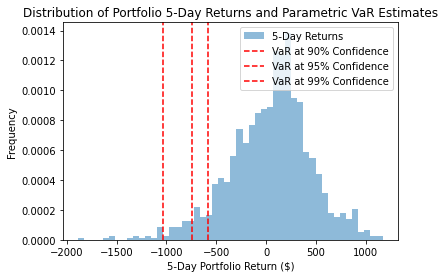

In [34]:
import matplotlib.pyplot as plt

# Assuming historical_x_day_returns and VaRs are correctly calculated
# and that VaRs are negative values representing losses

# Convert returns to dollar values for the histogram
historical_x_day_returns = historical_x_day_returns * portfolio_value

# Plot the histogram
plt.hist(historical_x_day_returns, bins=50, density=True, alpha=0.5, label=f'{days}-Day Returns')

# Add vertical lines representing VaR at each confidence level
for cl, VaR in zip(confidence_levels, VaRs):
    # Check if VaR is negative; if not, make it negative to represent a loss correctly
    VaR_to_plot = VaR if VaR < 0 else -VaR
    plt.axvline(x=VaR_to_plot, linestyle='--', color='r', label=f'VaR at {int(cl * 100)}% Confidence')

plt.xlabel(f'{days}-Day Portfolio Return ($)')
plt.ylabel('Frequency')
plt.title(f'Distribution of Portfolio {days}-Day Returns and Parametric VaR Estimates')
plt.legend()
plt.show()
